#AIAB 2nd Report

Investigating the fitness of a Full Microbial Genetic Algorithm (FMGA) with change in the number of tournamnets and change in the crossover rate

1st part: change in fitness of FMGA as the number of tournaments increases.

2nd part: change in fitness of FMGA as the cross-over rate increases.

3rd part: finding the optimal number of tournaments and cross-over rate to maximise the fitness of the FMGA.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from statistics import mean
import seaborn as sns
from matplotlib.lines import Line2D
from tabulate import tabulate

##Measuring fitness

We will be measuring the fitness of our FMGA using the knapsack problem. We will define one large knapsack problem (40 items) and use it for every FMGA in this notebook.

In [ ]:
#Function that solves the Knapsack problem
#Input: the maximum weight, the weights, values, and number of items
#Output: the maximum value that can be put in the knapsack
#Source: https://www.geeksforgeeks.org/0-1-knapsack-problem-dp-10/

def knapSack(W, wt, val, n):
  
    # Base Case
    if n == 0 or W == 0:
        return 0
  
    # If weight of the nth item is
    # more than Knapsack of capacity W,
    # then this item cannot be included
    # in the optimal solution
    if (wt[n-1] > W):
        return knapSack(W, wt, val, n-1)
  
    # return the maximum of two cases:
    # (1) nth item included
    # (2) not included
    else:
        return max(
            val[n-1] + knapSack(
                W-wt[n-1], wt, val, n-1),
            knapSack(W, wt, val, n-1))

In [ ]:
#Defining the knapsack problem we'll be using to evaluate our FMGAs

max_weight = 100
items_weights = [7, 4, 6, 5, 5, 6, 6, 5, 5, 1, 3, 3, 3, 6, 2, 7, 5, 1, 3, 6, 8, 3, 5, 3, 4, 6, 6, 4, 8, 5]
items_value = [10, 18, 16, 8, 8, 40, 11, 27, 3, 26, 28, 27, 11, 3, 44, 47, 31, 38, 37, 2, 23, 17, 4, 6, 43, 39, 47, 49, 47, 19]
items_num = len(items_value)

knapsack_solution = knapSack(max_weight, items_weights, items_value, items_num)
print("The solution to our knapsack problem is", knapsack_solution)

The solution to our knapsack problem is 685


We now need to define a fitness function. This is what will measure how well an FMGA is doing.

In [ ]:
#Function that returns the fitness of a genotype on a knapsack problem
#Input: the genotype, the knapsack problem's parameters (item values, item weights, maximum weight)
#Output: the total value the genotype puts in the knapsack, 0 if he goes over the maximum weight
#Source: given in the AIAB lab 2

def fitness_function(genotype, benefits, volumes, max_volume):
    
    # put you fitness calculuations here
    benefit_sum = 0
    volume_sum = 0

    for i in range(len(genotype)):
      if genotype[i] == 1: #we've selected that item to put in the bag
        benefit_sum += benefits[i]
        volume_sum += volumes[i]
      
    if volume_sum > max_volume:
      fitness = 0
    else:
      #fitness = max_volume-(max_volume-volume_sum)
      fitness = benefit_sum

    return fitness # a single number saying how good the geneotype is

In [ ]:
#Example of the fitness_function usage

genotype = np.random.randint(low=0,high=2,size=(items_num)) #creating a random genotype of the length of the number of items for our knapsack problem
resulting_fitness = fitness_function(genotype,items_value, items_weights, max_weight)#measuring its fitness
print('The resulting fitness of our genotype is', resulting_fitness)

The resulting fitness of our genotype is 280


##FMGA Algorithm

Before experimenting, we will define here how our algorithm works.

FMGA algorithm
1. Define knapsack problem
2. Initialise a random population of genotypes
3. Pick a random individual
4. Pick a random individual in the neighbourhood of the first one
5. Compare their fitness to get a winner and a loser
6. Copy the winner's genes into the loser's genotype with a crossover probability
7. Mutate the loser's new genotype
8. Compare the fitness of the loser's new genotype with it's original one and replace it in the population if the new one is better
9. Repeat from step 3 until we reach a predifined number of tournaments

In [ ]:
# Initialising a random population of genotypes

population = []
for i in range(10):
  population.append(np.random.randint(2,size=10))
population = np.array(population)

print('Population:')
print(np.array(population),'\n')

print('Individual at index 3:',population[3]) #Referencing a specific individual in the population

Population:
[[1 0 1 1 1 0 0 1 1 0]
 [1 1 0 1 0 0 1 1 0 0]
 [1 0 1 0 1 1 0 1 0 0]
 [0 0 0 1 0 0 0 0 1 0]
 [1 1 0 1 1 0 0 1 0 1]
 [1 1 0 0 1 0 0 0 1 1]
 [1 0 0 1 1 0 1 0 1 0]
 [0 1 0 1 0 0 0 0 1 1]
 [0 0 0 1 0 0 0 1 1 1]
 [0 0 0 1 1 1 1 0 1 1]] 

Individual at index 3: [0 0 0 1 0 0 0 0 1 0]


In [ ]:
# Picking an individual at random from our population

first_random_index = np.random.randint(len(population))
first_genotype = population[first_random_index]
print('Individual at index {} has the genotype {}'.format(first_random_index,first_genotype))

Individual at index 9 has the genotype [0 0 0 1 1 1 1 0 1 1]


In [ ]:
# Picking an individual in the neighbourhood

k = 2 #the size of the neighbourhood

#Getting a random integer in the neighbourhood of the first_random_index that IS NOT first_random_index
second_random_index = first_random_index
while second_random_index == first_random_index:
  second_random_index = np.random.randint(low=first_random_index-(k/2), high=first_random_index+(k/2)+1) % len(population)
second_genotype = population[second_random_index]

print('The picked individual is at index {} and has the genotype {}'.format(second_random_index,second_genotype))

The picked individual is at index 0 and has the genotype [1 0 1 1 1 0 0 1 1 0]


In [ ]:
# Compare the fitness of the two genotypes to define a winner and a loser

#Redefining our knapSack problem
items_value = [5, 6, 1, 9, 2, 8, 4, 3, 7, 10]
items_weights = [3, 2, 4, 5, 8, 9, 10, 1, 6, 7]
max_weight = 20

#Getting the fitness of each genotypes
first_genotype_fitness = fitness_function(first_genotype, items_value, items_weights, max_weight)
second_genotype_fitness = fitness_function(second_genotype, items_value, items_weights, max_weight)
print("First genotype's fitness is", first_genotype_fitness)
print("Second genotype's fitness is", second_genotype_fitness)

print('\n')
print('{} vs {}'.format(first_genotype,second_genotype))
print('\n')

#Defining the winner and the loser by comparing their fitness
winner_index = second_random_index if first_genotype_fitness < second_genotype_fitness else first_random_index
loser_index = first_random_index if first_genotype_fitness < second_genotype_fitness else second_random_index
print('Winner:', population[winner_index])
print('Loser:', population[loser_index])

First genotype's fitness is 0
Second genotype's fitness is 0


[0 0 0 1 1 1 1 0 1 1] vs [1 0 1 1 1 0 0 1 1 0]


Winner: [0 0 0 1 1 1 1 0 1 1]
Loser: [1 0 1 1 1 0 0 1 1 0]


In [ ]:
# Copying the genes of the Winner to the Loser with a crossover probability of 0.5

crossover_probability = 0.5

loser_replacement = []

for i in range(len(population[loser_index])):
  if np.random.rand(1) <= crossover_probability:
    new_gene = population[winner_index][i]
    loser_replacement.append(new_gene)
  else: loser_replacement.append(population[loser_index][i])

loser_replacement = np.array(loser_replacement)

print('The loser genotype {} became {}'.format(population[loser_index],loser_replacement))

The loser genotype [1 0 1 1 1 0 0 1 1 0] became [1 0 1 1 1 0 1 1 1 0]


In [ ]:
# Add one mutation to the loser replacemenet

mutation_index = np.random.randint(len(population[loser_index]))
if loser_replacement[mutation_index] == 0: loser_replacement[mutation_index] = 1
else: loser_replacement[mutation_index] = 0

print("The loser's replacement got mutated to {}".format(loser_replacement))

The loser's replacement got mutated to [1 0 1 1 1 0 1 1 0 0]


In [ ]:
# Compare the loser's new genotype to its original one

loser_replacement_fitness = fitness_function(loser_replacement, items_value, items_weights, max_weight)
loser_replacement = np.array(loser_replacement)

if loser_replacement_fitness > fitness_function(population[loser_index], items_value, items_weights, max_weight):
  #Replacing the loser in the population by our new loser's replacement's mutation
  population[loser_index] = loser_replacement

In [ ]:
# Replacing the loser in the population by our new loser's replacement's mutation

print('Original population:')
print(population,'\n')

population[loser_index] = loser_replacement

print('New population:')
print(population)

Original population:
[[1 0 1 1 1 0 0 1 1 0]
 [1 1 0 1 0 0 1 1 0 0]
 [1 0 1 0 1 1 0 1 0 0]
 [0 0 0 1 0 0 0 0 1 0]
 [1 1 0 1 1 0 0 1 0 1]
 [1 1 0 0 1 0 0 0 1 1]
 [1 0 0 1 1 0 1 0 1 0]
 [0 1 0 1 0 0 0 0 1 1]
 [0 0 0 1 0 0 0 1 1 1]
 [0 0 0 1 1 1 1 0 1 1]] 

New population:
[[1 0 1 1 1 0 1 1 0 0]
 [1 1 0 1 0 0 1 1 0 0]
 [1 0 1 0 1 1 0 1 0 0]
 [0 0 0 1 0 0 0 0 1 0]
 [1 1 0 1 1 0 0 1 0 1]
 [1 1 0 0 1 0 0 0 1 1]
 [1 0 0 1 1 0 1 0 1 0]
 [0 1 0 1 0 0 0 0 1 1]
 [0 0 0 1 0 0 0 1 1 1]
 [0 0 0 1 1 1 1 0 1 1]]


Here is the full function that does all of the steps of the FMGA algorithm defined above.

In [ ]:
#Function that defines and runs a Full Microbial GA
#Input: the number of tournaments, optionally the crossover probability
#Output: the fitness of each member of the population at each tournament

def FMGA(num_tournaments=10, population_size=100, num_genes=30, crossover_probability=0.5, keepMaxOnly=False, initial_diversity_probability=0.5):

  #Defining our knapSack problem
  items_value = [10, 18, 16, 8, 8, 40, 11, 27, 3, 26, 28, 27, 11, 3, 44, 47, 31, 38, 37, 2, 23, 17, 4, 6, 43, 39, 47, 49, 47, 19]
  items_weights = [7, 4, 6, 5, 5, 6, 6, 5, 5, 1, 3, 3, 3, 6, 2, 7, 5, 1, 3, 6, 8, 3, 5, 3, 4, 6, 6, 4, 8, 5]
  max_weight = 100

  k = 2 #Size of neighbourhood

  #Defining the initial population
  population = []
  for i in range(population_size):
    new_individual = np.arange(0, num_genes/2, 0.5, dtype=int) #only 0s
    for j in range(len(new_individual)):
      if np.random.rand(1) <= initial_diversity_probability:
          new_individual[j] = 1
    population.append(new_individual)
  population = np.array(population)

  population_fitness_evolution = []

  #Running the tournaments
  for i in range(num_tournaments):
    original_population = np.copy(population)

    #Picking a random individual
    first_random_index = np.random.randint(len(population))
    first_genotype = np.copy(population[first_random_index])

    #Picking an individual in the first individual's neighbourhood
    second_random_index = first_random_index
    while second_random_index == first_random_index: second_random_index = np.random.randint(low=first_random_index-(k/2), high=first_random_index+(k/2)+1) % len(population)
    second_genotype = np.copy(population[second_random_index])

    #Getting a winner and a loser
    first_genotype_fitness = fitness_function(first_genotype, items_value, items_weights, max_weight)
    second_genotype_fitness = fitness_function(second_genotype, items_value, items_weights, max_weight)

    winner_index = second_random_index if first_genotype_fitness < second_genotype_fitness else first_random_index
    loser_index = first_random_index if first_genotype_fitness < second_genotype_fitness else second_random_index

    #Replacing the loser with some of the winner's genes ('some' depends on the crossover probability)
    loser_replacement = []

    for j in range(len(population[loser_index])):
      if np.random.rand(1) <= crossover_probability:
        new_gene = np.copy(population[winner_index][j])
        loser_replacement.append(new_gene)
      else: loser_replacement.append(population[loser_index][j])

   

    #Adding a mutation to the loser's replacement
    mutation_index = np.random.randint(len(population[loser_index]))
    if loser_replacement[mutation_index] == 0: loser_replacement[mutation_index] = 1
    else: loser_replacement[mutation_index] = 0
    
    loser_replacement_fitness = fitness_function(loser_replacement, items_value, items_weights, max_weight)
    original_fitness = fitness_function(population[loser_index], items_value, items_weights, max_weight)

    if loser_replacement_fitness > original_fitness:
      #print(i,loser_replacement_fitness,fitness_function(population[loser_index], items_value, items_weights, max_weight))
      #Replacing the loser in the population by our new loser's replacement's mutation
      population[loser_index] = loser_replacement

    #if original_population.tolist() != population.tolist(): print(loser_replacement_fitness, original_fitness)

    #print(i, original_population.tolist() == population.tolist())

    #Get the fitness of each genotype and add it to the population_fitness list
    fitness_tournament = []
    for genotype in population:
      fitness = fitness_function(genotype, items_value, items_weights, max_weight)
      fitness_tournament.append(fitness)
    if keepMaxOnly: population_fitness_evolution.append(max(fitness_tournament))
    else: population_fitness_evolution.append(fitness_tournament)

  return population_fitness_evolution

##PART 1: FMGA fitness vs. number of tournaments

We will now explore how well our FMGAs do with an increasing number of tournaments.


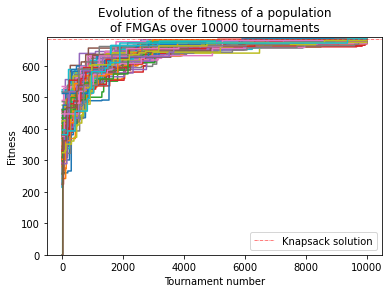

In [ ]:
#Plotting the evolution of a population of FMGAs over an arbitrary number of tournaments

fitnesses = FMGA(num_tournaments=10000, population_size=100, num_genes=items_num, crossover_probability=0.5, initial_diversity_probability=0.5)
fitnesses = np.array(fitnesses)

plt.plot(fitnesses)
plt.title('Evolution of the fitness of a population\nof FMGAs over 10000 tournaments')
plt.ylabel('Fitness')
plt.xlabel('Tournament number')
plt.ylim([0,knapsack_solution+5])
plt.axhline(y=knapsack_solution, color='r', linestyle='-.', linewidth=0.5)
legend_elements = [Line2D([0], [0], color='r', lw=0.5, linestyle='-.', label='Knapsack solution')]
plt.legend(handles=legend_elements, loc="lower right")
plt.show()

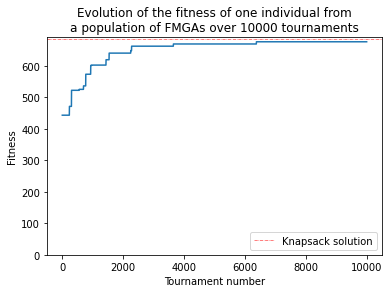

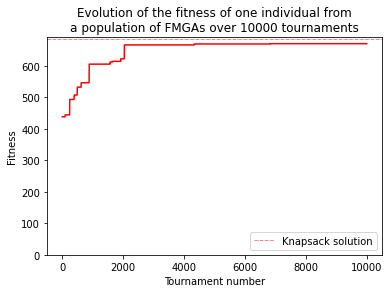

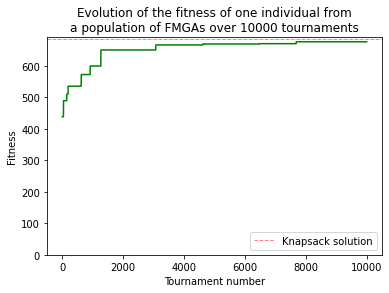

In [ ]:
#Plotting the fitness of individualds individually (as to not get the messy plot from above)

individual_one_fitness = fitnesses[:,0]
plt.plot(individual_one_fitness)
plt.title('Evolution of the fitness of one individual from\na population of FMGAs over 10000 tournaments')
plt.ylabel('Fitness')
plt.xlabel('Tournament number')
plt.ylim([0,knapsack_solution+5])
plt.axhline(y=knapsack_solution, color='r', linestyle='-.', linewidth=0.5)
legend_elements = [Line2D([0], [0], color='r', lw=0.5, linestyle='-.', label='Knapsack solution')]
plt.legend(handles=legend_elements, loc="lower right")
plt.show()

individual_one_fitness = fitnesses[:,1]
plt.plot(individual_one_fitness, color='red')
plt.title('Evolution of the fitness of one individual from\na population of FMGAs over 10000 tournaments')
plt.ylabel('Fitness')
plt.xlabel('Tournament number')
plt.ylim([0,knapsack_solution+5])
plt.axhline(y=knapsack_solution, color='r', linestyle='-.', linewidth=0.5)
legend_elements = [Line2D([0], [0], color='r', lw=0.5, linestyle='-.', label='Knapsack solution')]
plt.legend(handles=legend_elements, loc="lower right")
plt.show()

individual_one_fitness = fitnesses[:,2]
plt.plot(individual_one_fitness, color='green')
plt.title('Evolution of the fitness of one individual from\na population of FMGAs over 10000 tournaments')
plt.ylabel('Fitness')
plt.xlabel('Tournament number')
plt.ylim([0,knapsack_solution+5])
plt.axhline(y=knapsack_solution, color='r', linestyle='-.', linewidth=0.5)
legend_elements = [Line2D([0], [0], color='r', lw=0.5, linestyle='-.', label='Knapsack solution')]
plt.legend(handles=legend_elements, loc="lower right")
plt.show()

Plotting the average best fitness of 5 FMGAs at each tournament over 6000 tournaments

In [ ]:
#Plotting the best fitness at each tournament, averaged over 3 FMGAs
#The 3 FMGAs' best individual are plotted as dashed lines (black line)
#The average is plotted as a full line

average_best_fitness = []
FMGA_best_fitnesses_all = []

num_tournaments = 10001
num_FMGAs = 5

FMGAs = [FMGA(num_tournaments=num_tournaments, population_size=100, num_genes=items_num, crossover_probability=0.5) for i in range(num_FMGAs)]
for i in range(num_tournaments):
  best_fitness_tournament = []
  for model in FMGAs:
    best_fitness_tournament.append(max(model[i]))
  average_best_fitness.append(mean(best_fitness_tournament))  
  FMGA_best_fitnesses_all.append(best_fitness_tournament)

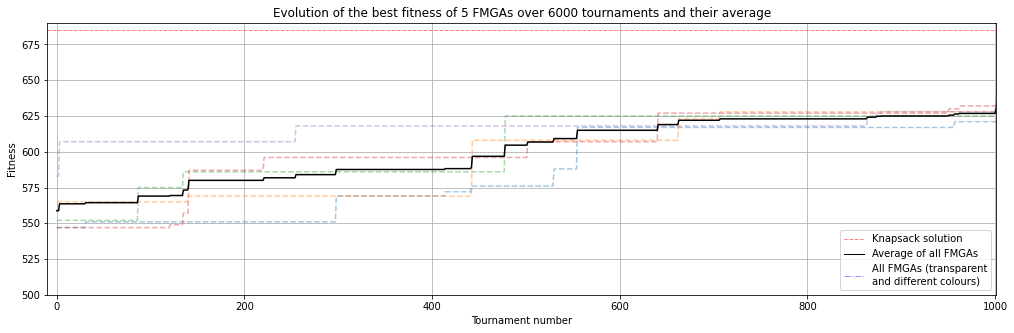

╒═════════════════════════╤═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤════════╤═════════════════════╕
│ Number of tournaments   │   0 │   100 │   200 │   300 │   400 │   500 │   600 │   700 │   800 │   900 │   1000 │   Knapsack solution │
╞═════════════════════════╪═════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪════════╪═════════════════════╡
│ Average best fitness    │ 559 │   569 │   580 │   588 │   588 │   605 │   615 │   622 │   623 │   625 │    627 │                 685 │
╘═════════════════════════╧═════╧═══════╧═══════╧═══════╧═══════╧═══════╧═══════╧═══════╧═══════╧═══════╧════════╧═════════════════════╛


In [ ]:
figure = plt.figure(figsize=(17,5))
plt.plot(FMGA_best_fitnesses_all, linestyle='dashed', alpha=0.4)
plt.plot(average_best_fitness, color='black')
plt.title('Evolution of the best fitness of 5 FMGAs over 6000 tournaments and their average')
plt.ylabel('Fitness')
plt.xlabel('Tournament number')
plt.xlim([-10,1001])
plt.ylim([500,knapsack_solution+5])
plt.axhline(y=knapsack_solution, color='r', linestyle='-.', linewidth=0.5)
legend_elements = [Line2D([0], [0], color='r', lw=0.5, linestyle='-.', label='Knapsack solution'),
                   Line2D([0], [0], color='black', lw=1, linestyle='-', label='Average of all FMGAs'),
                   Line2D([0], [0], color='blue', lw=1, linestyle='-.', alpha=0.4, label='All FMGAs (transparent\nand different colours)')]
plt.grid() 
plt.legend(handles=legend_elements,loc="lower right")
plt.show()

#Add a table that shows the average of all FMGAs every 1000 tournaments


enumerated_abf = np.array([(i,round(v)) for i,v in enumerate(average_best_fitness) if i % 100 == 0])
table = [['Number of tournaments', enumerated_abf[0][0], enumerated_abf[1][0], enumerated_abf[2][0], enumerated_abf[3][0], enumerated_abf[4][0], enumerated_abf[5][0], enumerated_abf[6][0], enumerated_abf[7][0], enumerated_abf[8][0], enumerated_abf[9][0], enumerated_abf[10][0], 'Knapsack solution'],
         ['Average best fitness', enumerated_abf[0][1], enumerated_abf[1][1], enumerated_abf[2][1], enumerated_abf[3][1], enumerated_abf[4][1], enumerated_abf[5][1], enumerated_abf[6][1], enumerated_abf[7][1], enumerated_abf[8][1], enumerated_abf[9][1], enumerated_abf[10][1], knapsack_solution]]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

In [ ]:
#Printing the correlation coefficient between the number of tournaments (up to 1000) and the average best fitness
r = np.corrcoef(enumerated_abf[:,0][:11], enumerated_abf[:,1][:11])
print('Pearson correlation score up to 1000 tournaments with fitness:',r[0, 1])

Pearson correlation score up to 1000 tournaments with fitness: 0.9742809818406456


In [ ]:
#Printing the correlation coefficient between the number of tournaments (up to 10'000) and the average best fitness
r = np.corrcoef(enumerated_abf[:,0][:110], enumerated_abf[:,1][:110])
print('Pearson correlation score up to 10\'000 tournaments with fitness:',r[0, 1])

Pearson correlation score up to 10'000 tournaments with fitness: 0.7007580419773446


In [ ]:
#Printing the correlation coefficient between the number of tournaments (from 3'000 to 10'000) and the average best fitness
r = np.corrcoef(enumerated_abf[:,0][30:110], enumerated_abf[:,1][30:110])
print('Pearson correlation score up to 10\'000 tournaments with fitness:',r[0, 1])

Pearson correlation score up to 10'000 tournaments with fitness: 0.7283513877789177


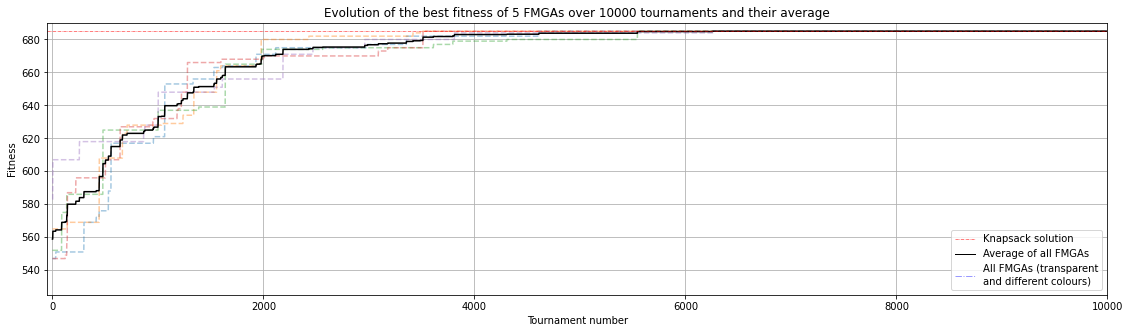

╒═════════════════════════╤═════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤═════════╤═════════════════════╕
│ Number of tournaments   │   0 │   1000 │   2000 │   3000 │   4000 │   5000 │   6000 │   7000 │   8000 │   9000 │   10000 │   Knapsack solution │
╞═════════════════════════╪═════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪═════════╪═════════════════════╡
│ Average best fitness    │ 559 │    627 │    670 │    677 │    683 │    684 │    685 │    685 │    685 │    685 │     685 │                 685 │
╘═════════════════════════╧═════╧════════╧════════╧════════╧════════╧════════╧════════╧════════╧════════╧════════╧═════════╧═════════════════════╛


In [ ]:
figure = plt.figure(figsize=(19,5))
plt.plot(FMGA_best_fitnesses_all, linestyle='dashed', alpha=0.4)
plt.plot(average_best_fitness, color='black')
plt.title('Evolution of the best fitness of 5 FMGAs over 10000 tournaments and their average')
plt.ylabel('Fitness')
plt.xlabel('Tournament number')
plt.xlim([-50,10000])
plt.ylim([525,knapsack_solution+5])
plt.axhline(y=knapsack_solution, color='r', linestyle='-.', linewidth=0.5)
legend_elements = [Line2D([0], [0], color='r', lw=0.5, linestyle='-.', label='Knapsack solution'),
                   Line2D([0], [0], color='black', lw=1, linestyle='-', label='Average of all FMGAs'),
                   Line2D([0], [0], color='blue', lw=1, linestyle='-.', alpha=0.4, label='All FMGAs (transparent\nand different colours)')]
plt.grid() 
plt.legend(handles=legend_elements,loc="lower right")
plt.show()

#Add a table that shows the average of all FMGAs every 1000 tournaments


enumerated_abf = np.array([(i,round(v)) for i,v in enumerate(average_best_fitness) if i % 1000 == 0])
table = [['Number of tournaments', enumerated_abf[0][0], enumerated_abf[1][0], enumerated_abf[2][0], enumerated_abf[3][0], enumerated_abf[4][0], enumerated_abf[5][0], enumerated_abf[6][0], enumerated_abf[7][0], enumerated_abf[8][0], enumerated_abf[9][0],enumerated_abf[10][0],'Knapsack solution'],
         ['Average best fitness', enumerated_abf[0][1], enumerated_abf[1][1], enumerated_abf[2][1], enumerated_abf[3][1], enumerated_abf[4][1], enumerated_abf[5][1], enumerated_abf[6][1], enumerated_abf[7][1],enumerated_abf[8][1],enumerated_abf[9][1],enumerated_abf[10][1], knapsack_solution]]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

In [ ]:
#Printing the correlation coefficient between the number of tournaments (up to 6000) and the average best fitness
r = np.corrcoef(enumerated_abf[:,0], enumerated_abf[:,1])
print('Pearson correlation score:',r[0, 1])

Pearson correlation score: 0.7078330834327378


We can clearly see that as the number of tournaments increases, the better the FMGAs get. Moreover, there is a strong correlation between the two (0.72 Pearson correlation), even if it starts plateauing after 1000 tournaments.

##PART 2: FMGA fitness vs crossover probability 

We will now explore how well our FMGA performs as the crossover probability increases. We choose to have 10000 tournaments when we test it as we found (above in this notebook) that with a crossover proability of 0.5 it brings it, on average, to the knapsack solution.

In [ ]:
crossover_probabilities = [i/100 for i in range(0,110,10)]
print(crossover_probabilities)
tournament_fitnesses = []

for i in range(len(crossover_probabilities)):
  print(str(i+1) + '/' + str(len(crossover_probabilities)))
  tournament_fitness = 0
  for j in range(3):
    tournament_fitness += max(FMGA(num_tournaments=10000, population_size=50, num_genes=30, crossover_probability=crossover_probabilities[i])[-1])
  tournament_fitnesses.append(tournament_fitness/3)

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
1/11
2/11
3/11
4/11
5/11
6/11
7/11
8/11
9/11
10/11
11/11


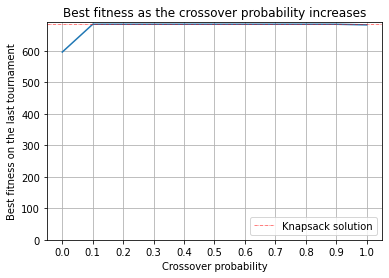

In [ ]:
df = DataFrame({'Crossover probability':crossover_probabilities, 'Best fitness on the last tournament':tournament_fitnesses})
df.plot.line(x='Crossover probability', y='Best fitness on the last tournament')
plt.xlabel('Crossover probability')
plt.ylabel('Best fitness on the last tournament')
plt.xticks([i/10 for i in range(0,11,1)])
plt.ylim([0,knapsack_solution+6])
plt.title('Best fitness as the crossover probability increases')

plt.axhline(y=knapsack_solution, color='r', linestyle='-.', linewidth=0.5)
legend_elements = [Line2D([0], [0], color='r', lw=0.5, linestyle='-.', label='Knapsack solution')]
plt.legend(handles=legend_elements, loc="lower right")

plt.grid()
plt.show()

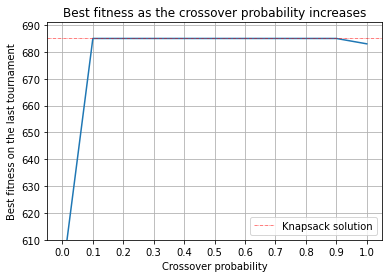

In [ ]:
df = DataFrame({'Crossover probability':crossover_probabilities, 'Best fitness on the last tournament':tournament_fitnesses})
df.plot.line(x='Crossover probability', y='Best fitness on the last tournament')
plt.xlabel('Crossover probability')
plt.ylabel('Best fitness on the last tournament')
plt.xticks([i/10 for i in range(0,11,1)])
plt.ylim([610,knapsack_solution+6])
plt.title('Best fitness as the crossover probability increases')

plt.axhline(y=knapsack_solution, color='r', linestyle='-.', linewidth=0.5)
legend_elements = [Line2D([0], [0], color='r', lw=0.5, linestyle='-.', label='Knapsack solution')]
plt.legend(handles=legend_elements, loc="lower right")

plt.grid()
plt.show()

In [ ]:
#Plot fitness change in FMGAs with different crossover probability

crossover_probabilities = [i/100 for i in range(0,101,10)]
print(crossover_probabilities)
num_tournaments = 5000


FMGA_best_fitnesses_cross_prob = []
for i in range(len(crossover_probabilities)):
  print(crossover_probabilities[i])
  #make three models at that idp
  average_at_each_tournament = []
  models = [FMGA(num_tournaments=num_tournaments, population_size=100, num_genes=items_num, crossover_probability=crossover_probabilities[i]) for x in range(3)]
  for j in range(num_tournaments):
    average_at_each_tournament.append(mean([max(models[0][j]),max(models[1][j]),max(models[2][j])]))
  FMGA_best_fitnesses_cross_prob.append(average_at_each_tournament)

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


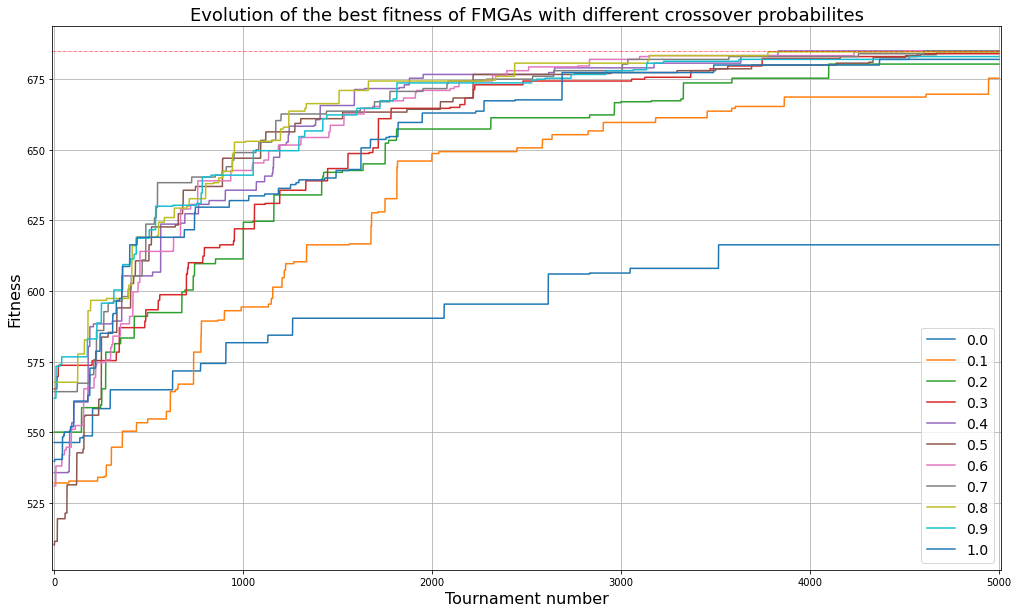

In [ ]:
figure = plt.figure(figsize=(17,10))

for i in range(len(FMGA_best_fitnesses_cross_prob)):
  plt.plot(FMGA_best_fitnesses_cross_prob[i], label=crossover_probabilities[i])

plt.title('Evolution of the best fitness of FMGAs with different crossover probabilites', fontsize=18)
plt.ylabel('Fitness',fontsize=16)
plt.xlabel('Tournament number',fontsize=16)
plt.xlim([-10,5010])
#plt.ylim([500,knapsack_solution+5])
plt.axhline(y=knapsack_solution, color='r', linestyle='-.', linewidth=0.5)

#legend_elements = []
#for idp in initial_diversity_probabilities:
  #legend_elements.append(Line2D([0], [0], lw=0.5, label=idp))

plt.grid() 
plt.legend(loc="lower right", fontsize=14)
plt.show()


We can notice that the two extremes perform worse than in the middle.

In [ ]:
#Plot fitness change in FMGAs with different initial_diversity_probability
FMGA_best_fitnesses_all = []
initial_diversity_prob_to_test = [i/100 for i in range(0,101,10)]
print(initial_diversity_prob_to_test)
num_tournaments = 5000

average_model_performance_per_diversity = []
for i in range(len(initial_diversity_prob_to_test)):
  print(initial_diversity_prob_to_test[i])
  #make three models at that idp
  average_at_each_tournament = []
  models = [FMGA(num_tournaments=num_tournaments, population_size=100, num_genes=items_num, initial_diversity_probability=initial_diversity_prob_to_test[i], ) for x in range(3)]
  for j in range(num_tournaments):
    average_at_each_tournament.append(mean([max(models[0][j]),max(models[1][j]),max(models[2][j])]))
  average_model_performance_per_diversity.append(average_at_each_tournament)

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


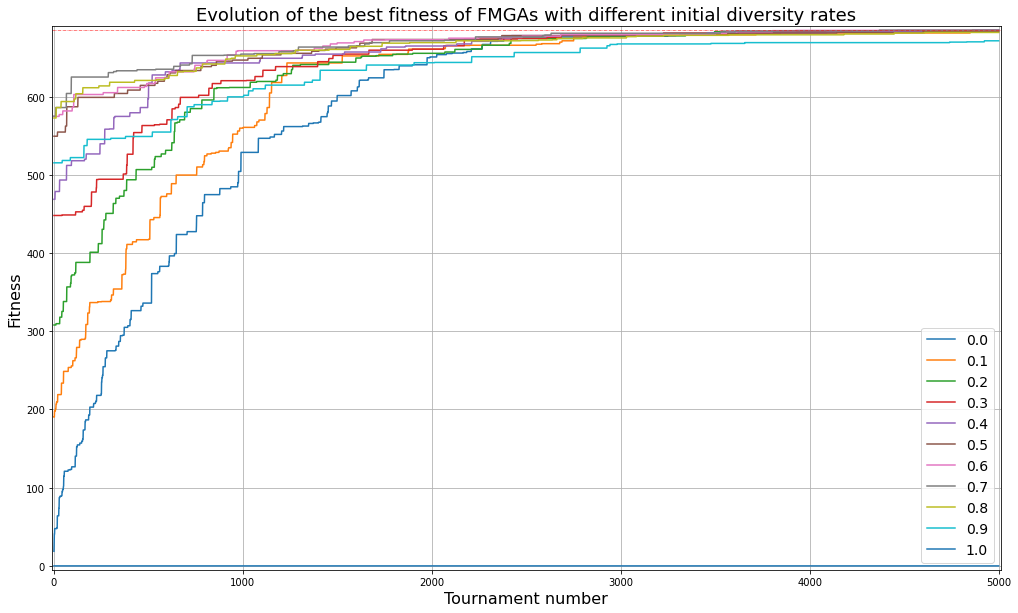

In [ ]:
figure = plt.figure(figsize=(17,10))

for i in range(len(average_model_performance_per_diversity)):
  plt.plot(average_model_performance_per_diversity[i], label=crossover_probabilities[i])

plt.title('Evolution of the best fitness of FMGAs with different initial diversity rates', fontsize=18)
plt.ylabel('Fitness', fontsize=16)
plt.xlabel('Tournament number', fontsize=16)
plt.xlim([-10,5010])
plt.ylim([-5,knapsack_solution+5])
plt.axhline(y=knapsack_solution, color='r', linestyle='-.', linewidth=0.5)

#legend_elements = []
#for idp in initial_diversity_probabilities:
  #legend_elements.append(Line2D([0], [0], lw=0.5, label=idp))

plt.grid() 
plt.legend(loc="lower right", fontsize=14)
plt.show()


In [ ]:
#Getting the Pearson correlation score for crossover probability and fitness

r = np.corrcoef(crossover_probabilities, tournament_fitnesses)
print('Pearson correlation score:',r[0, 1])

Pearson correlation score: 0.48966339610221016


In [ ]:
crossover_probabilities = [i/100 for i in range(0,101,10)]
print(crossover_probabilities)
tournament_results = []

for i in range(len(crossover_probabilities)):
  if (i+1)%10 == 0: print(str(i+1) + '/' + str(len(crossover_probabilities)))
  tournament_result = []
  for j in range(3):
    tournament_result.append(FMGA(num_tournaments=1000, population_size=50, num_genes=30, crossover_probability=crossover_probabilities[i])[-1])
  tournament_result = np.reshape(np.array(tournament_result),(len(tournament_result[0]*3)))
  tournament_results.append(tournament_result)

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
10/11


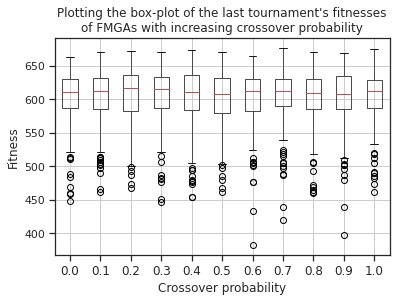

In [ ]:
data = np.reshape(tournament_results,(len(tournament_results[0]),len(tournament_results)))
df = pd.DataFrame(data, columns=crossover_probabilities)
boxplot = df.boxplot(column=crossover_probabilities,color=dict(medians='r'))  
plt.title('Plotting the box-plot of the last tournament\'s fitnesses\nof FMGAs with increasing crossover probability')
plt.xlabel('Crossover probability')
plt.ylabel('Fitness')
plt.xticks(fontsize=12)
plt.show()

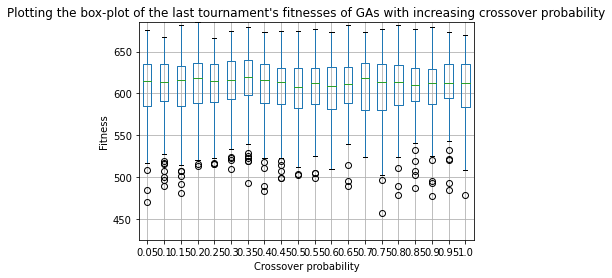

In [ ]:
data = np.reshape(tournament_results,(len(tournament_results[0]),len(tournament_results)))
df = pd.DataFrame(data, columns=crossover_probabilities)
boxplot = df.boxplot(column=crossover_probabilities)  
plt.title('Plotting the box-plot of the last tournament\'s fitnesses of GAs with increasing crossover probability')
plt.ylim([425,685])
plt.xlabel('Crossover probability')
plt.ylabel('Fitness')
plt.show()

We don't notice significant deviations in crossover rates' mean and spread on these plots.

We assume that when crossing over, the winner is giving some of his 'winning genes' to the loser's 'losing genes'. These genes, before any tournament has started, come from a random assignment of 50% probability. This means that even if crossover probability defines the diversity of the data at each tournament, and that there is more diversity with 50% probabilites, it is still bound by the initial assignement's probability. Here's an example: if the initial genes were all the exact same, it does not matter what crossover rate each tourmanent applies, there will never be a change in the population and its fitness will neevr change. Opposingly, we make the hypothesis that a very diverse initial population and a crossover rate that promotes diversity (0.5) will create FMGAs that converge to the solution faster.

We will call the initial diversity of the population the 'diversity rate'. A population with genotypes of only 0s will be created, and the diversity rate will define the probability for those genes to change to 1s. With a diversity rate of 0.5, we can expect a typical gene to have the following diversity [0,0,0,0,0,1,1,1,1,1]

In [ ]:
#Plot average fitness as initial_diversity_probability increases
initial_diversity_probabilities = [i/100 for i in range(0,101,1)]
print(initial_diversity_probabilities)
initial_diversity_fitness = []

for i in range(len(initial_diversity_probabilities)):
  if (i+1)%10 == 0: print(str(i+1) + '/' + str(len(initial_diversity_probabilities)))
  fitness = 0
  for j in range(3):
    fitness += max(FMGA(num_tournaments=1000, population_size=50, num_genes=30, crossover_probability=0.5, initial_diversity_probability = initial_diversity_probabilities[i])[-1])
  initial_diversity_fitness.append(fitness/3)

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0]
10/101
20/101
30/101
40/101
50/101
60/101
70/101
80/101
90/101
100/101


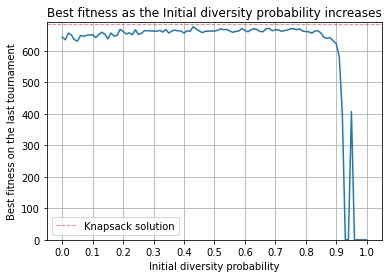

In [ ]:
df = DataFrame({'Initial diversity probability':initial_diversity_probabilities, 'Best fitness on the last tournament':initial_diversity_fitness})
df.plot.line(x='Initial diversity probability', y='Best fitness on the last tournament')
plt.xlabel('Initial diversity probability')
plt.ylabel('Best fitness on the last tournament')
plt.xticks([i/10 for i in range(0,11,1)])
plt.ylim([0,knapsack_solution+6])
plt.title('Best fitness as the Initial diversity probability increases')

plt.axhline(y=knapsack_solution, color='r', linestyle='-.', linewidth=0.5)
legend_elements = [Line2D([0], [0], color='r', lw=0.5, linestyle='-.', label='Knapsack solution')]
plt.legend(handles=legend_elements, loc="lower left")

plt.grid()
plt.show()

In [ ]:
#Plot fitness change in FMGAs with different initial_diversity_probability
FMGA_best_fitnesses_all = []
initial_diversity_probabilities = [i/100 for i in range(0,101,10)]
initial_diversity_probabilities = [1]
print(initial_diversity_probabilities)
num_tournaments = 10001

average_model_performance_per_diversity = []
for i in range(len(initial_diversity_probabilities)):
  #make three models at that idp
  average_at_each_tournament = []
  models = [FMGA(num_tournaments=num_tournaments, population_size=100, num_genes=items_num, crossover_probability=0.5, initial_diversity_probability=initial_diversity_probabilities[i]) for x in range(3)]
  for j in range(num_tournaments):
    average_at_each_tournament.append(mean([max(models[0][j]),max(models[1][j]),max(models[2][j])]))
  average_model_performance_per_diversity.append(average_at_each_tournament)

[1]


In [ ]:
#Plot a heatmap of the best crossover rate and diversity rate

crossover_rates = [i/100 for i in range(0,101,10)]
initial_diversity_rates = [i/100 for i in range(0,101,10)]
print(crossover_rates)

num_tournaments = 100
fitness_progressions_per_model = []

cross_prob_col = []
idr_col = []
fit_col = []

for cross_prob in crossover_rates:
  print(cross_prob)
  for idr_rate in initial_diversity_rates:
    cross_prob_col.append(cross_prob)
    idr_col.append(idr_rate)

    fitness_total = 0
    for i in range(10):
      fitness_total += max(FMGA(num_tournaments=num_tournaments, population_size=100, num_genes=items_num, crossover_probability=cross_prob, initial_diversity_probability=idr_rate)[-1])
    
    fit_col.append(fitness_total/10)

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


Text(0.5, 1.0, 'Fitness of FMGA with varying crossover probability and initial diversity rate')

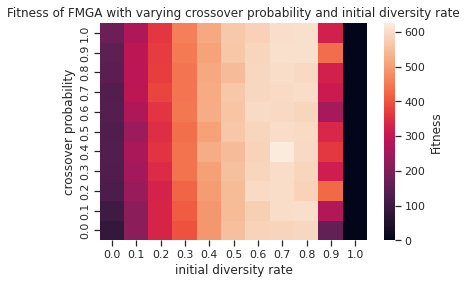

In [ ]:
df = pd.DataFrame(data={'crossover probability':cross_prob_col, 'initial diversity rate':idr_col, 'fitness':fit_col})
df = df.pivot('crossover probability', 'initial diversity rate', 'fitness')

ax = sns.heatmap(data=df, cbar_kws={'label': 'Fitness'})
ax.invert_yaxis()
ax.set_title('Fitness of FMGA with varying crossover probability and initial diversity rate')

##PART 3: Optimising FMGA with best number of tournaments and crossover probability

In [ ]:
num_tournaments_to_test = [i for i in range(1,10002,1000)]
crossover_probabilities = [i/100 for i in range(0,105,10)]

In [ ]:
num_tournaments_to_test = [i for i in range(1,10002,1000)]
crossover_probabilities = [i/100 for i in range(0,105,10)]

best_fitnesses_tournament = []

for i in range(len(num_tournaments_to_test)):
  if (i+1)%2 == 0: print(str(i+1) + '/' + str(len(num_tournaments_to_test)))
  best_fitnesses_cross = []
  for j in range(len(crossover_probabilities)):
    tournament_fitness = 0
    
    for k in range(3):
      tournament_fitness += max(FMGA(num_tournaments=num_tournaments_to_test[i], population_size=50, num_genes=30, crossover_probability=crossover_probabilities[j])[-1])
    best_fitnesses_cross.append(tournament_fitness/3)
    
  best_fitnesses_tournament.append(best_fitnesses_cross)

2/11
4/11
6/11
8/11
10/11


In [ ]:
print(num_tournaments_to_test)
print(crossover_probabilities)

[1, 1001, 2001, 3001, 4001, 5001, 6001, 7001, 8001, 9001]
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


In [ ]:

num_tournaments_to_test = [i for i in range(1,10250,300)]
crossover_probabilities = [i/100 for i in range(0,101,2)]

print(len(num_tournaments_to_test))
print(len(crossover_probabilities))

print(num_tournaments_to_test)
print(crossover_probabilities)

35
51
[1, 301, 601, 901, 1201, 1501, 1801, 2101, 2401, 2701, 3001, 3301, 3601, 3901, 4201, 4501, 4801, 5101, 5401, 5701, 6001, 6301, 6601, 6901, 7201, 7501, 7801, 8101, 8401, 8701, 9001, 9301, 9601, 9901, 10201]
[0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1.0]


In [ ]:
#Every time we train a model at a certain crossover probability, we can collect its fitness at each num_tournaments_to_test

num_tournaments_to_test = [i for i in range(1,10250,250)]
crossover_probabilities = [i/100 for i in range(0,101,1)]
print(crossover_probabilities)

best_fitnesses_cross_prob_tournament = []
cross_prob_col = []
num_tour_col = []

for cross_prob in crossover_probabilities:
  print(cross_prob)
  FMGA_mean_fitness_tournaments = [mean([x,y,z]) for x,y,z in zip(FMGA(num_tournaments=10500, population_size=50, num_genes=30, crossover_probability=cross_prob,keepMaxOnly=True),FMGA(num_tournaments=10500, population_size=50, num_genes=30, crossover_probability=cross_prob,keepMaxOnly=True),FMGA(num_tournaments=10500, population_size=50, num_genes=30, crossover_probability=cross_prob,keepMaxOnly=True))]
  for i in range(len(num_tournaments_to_test)):
    num_tour_col.append(num_tournaments_to_test[i])
    cross_prob_col.append(cross_prob)
    best_fitnesses_cross_prob_tournament.append(FMGA_mean_fitness_tournaments[num_tournaments_to_test[i]])
  
  #best_fitnesses_cross_prob_tournament.append([FMGA_mean_fitness_tournaments[num_tournaments] for num_tournaments in num_tournaments_to_test])
  #cross_prob_col.append()

Text(0.5, 1.0, 'Fitness of FMGA with varying crossover probability and number of tournaments')

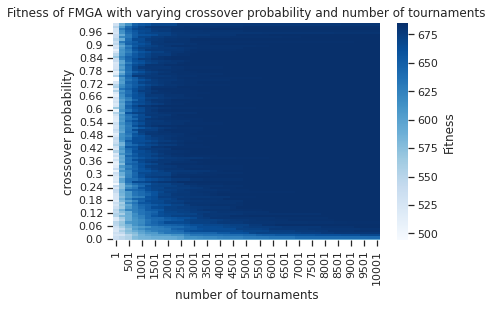

In [ ]:
df = pd.DataFrame(data={'crossover probability':cross_prob_col, 'number of tournaments':num_tour_col, 'fitness':best_fitnesses_cross_prob_tournament})
df = df.pivot('crossover probability', 'number of tournaments', 'fitness')

ax = sns.heatmap(data=df, cbar_kws={'label': 'Fitness'}, cmap="Blues")
ax.invert_yaxis()
#ax.set_yticks([0,5,100])
ax.set_title('Fitness of FMGA with varying crossover probability and number of tournaments')